In [41]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import os
import keras

from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, decode_predictions
from keras.layers import Dense, Flatten, Embedding, Input, Dropout, Concatenate, BatchNormalization, CuDNNGRU
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel

from scipy import sparse

## Declaring useful functions

In [11]:
def change_data_representation(df, feature_to_index_maps, data_folder, image_folder):
    
    empty_img_path = os.path.join(data_folder, "external", "empty_img.jpg")
    
    empty_img = Image.fromarray(np.zeros((224, 224, 3)).astype(np.uint8))
    empty_img_path = os.path.join(data_folder, "external", "empty_img.jpg")
    empty_img.save(empty_img_path)
    
    empty_img_relpath = os.path.relpath(empty_img_path, image_folder)
    
    num_df = df.assign(category_index = df.category_name.map(feature_to_index_maps[0]),
                       region_index = df.region.map(feature_to_index_maps[1]),
                       parent_category_index = df.parent_category_name.map(feature_to_index_maps[2]),
                       param_1_index = df.param_1.map(feature_to_index_maps[3]),
                       user_type_index = df.user_type.map(feature_to_index_maps[4]),
                       image_path = df.image + ".jpg",
                       days_since_activation_num = df.days_since_activation.str.slice(0,2).astype(int)
                      )
    
    num_df.fillna({"param_1_index" : 0,
                   "region_index" : 0,
                   "parent_category_index" : 0,
                   "user_type_index" : 0,
                   "category_index" : 0,
                   "description" : "",
                  "image_path" : empty_img_relpath},
                 inplace=True)
    
    num_df.price.fillna(num_df.groupby("category_name")["price"].transform("mean"),
                        inplace=True)

    features_to_keep = ["title", "description", "price", "deal_probability", "user_active_ads",\
                        "image_path", "category_index", "region_index", "parent_category_index",\
                       "param_1_index", "user_type_index", "days_since_activation_num"]

    num_df = num_df[features_to_keep]
    
    return num_df

In [12]:
def get_feature_to_index_maps(df):
    category_index_mapping = {category : int(index + 1) for index, category\
                              in enumerate(df.category_name.unique())}
    region_index_mapping = {region : int(index + 1) for index, region\
                            in enumerate(df.region.unique())}
    parent_category_index_mapping = {par_category : int(index + 1) for index, par_category\
                                     in enumerate(df.parent_category_name.unique())}
    param_1_index_mapping = {param_1 : int(index + 1) for index, param_1\
                             in enumerate(df.param_1.unique())}
    
    user_type_index_mapping = dict(zip(df.user_type.unique(), np.arange(1,4)))
    
    return [category_index_mapping, region_index_mapping, parent_category_index_mapping,\
            param_1_index_mapping, user_type_index_mapping]

In [13]:
def create_one_hot_encoder(df):
    one_hot_enc = OneHotEncoder(categories="auto", handle_unknown="ignore")
    categorical_columns = ["category_index", "region_index", "parent_category_index",\
                          "param_1_index", "user_type_index"]
    one_hot_enc.fit(df[categorical_columns])
    return one_hot_enc

In [14]:
def one_hot_encode(df, enc):
    categorical_columns = ["category_index", "region_index", "parent_category_index",\
                          "param_1_index", "user_type_index"]
    return enc.transform(df[categorical_columns])

In [15]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

In [10]:
data_folder = os.path.join(os.path.abspath(os.curdir), os.pardir, "data")
image_folder = image_folder = os.path.join(data_folder,
                                           "raw",
                                           "train_jpg",
                                           "data",
                                           "competition_files",
                                           "train_jpg")
training_data_path = os.path.join(data_folder, "interim", "trimmed_train_train.csv")
val_data_path = os.path.join(data_folder, "interim", "trimmed_train_validation.csv") 
raw_train_df = pd.read_csv(training_data_path)
raw_val_df = pd.read_csv(val_data_path)

## Setting up for experiment

In [16]:
feature_to_index_maps = get_feature_to_index_maps(raw_train_df)
train_df = change_data_representation(raw_train_df, feature_to_index_maps, data_folder, image_folder)
val_df = change_data_representation(raw_val_df, feature_to_index_maps, data_folder, image_folder)

In [17]:
enc = create_one_hot_encoder(train_df)
numerical_features = ["price", "user_active_ads", "days_since_activation_num"]

scaler = Normalizer()

train_cat_X = one_hot_encode(train_df, enc)
train_num_X = train_df[numerical_features].values
scaler.fit(train_num_X)
train_num_X = scaler.transform(train_num_X)
train_y = train_df.deal_probability.values

val_cat_X = one_hot_encode(val_df, enc)
val_num_X = val_df[numerical_features]
val_num_X = scaler.transform(val_num_X)
val_y = val_df.deal_probability.values

## Regular old TFIDFVectorizer

In [10]:
vectorizer = TfidfVectorizer()

In [22]:
train_df = train_df.assign(td = train_df.title + train_df.description)

In [23]:
vocabulary = train_df.td.values

In [13]:
vectorizer.fit(vocabulary)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [14]:
train_title = vectorizer.transform(train_df["title"].values)
val_title = vectorizer.transform(val_df["title"].values)

In [15]:
train_desc = vectorizer.transform(train_df["description"].values)
val_desc = vectorizer.transform(val_df["description"].values)

## RNN preprocessing

In [69]:
from keras.preprocessing.text import Tokenizer

In [70]:
from keras.preprocessing.sequence import pad_sequences

In [71]:
tokenizer = Tokenizer(num_words=10000)

In [72]:
tokenizer.fit_on_texts(vocabulary)

In [73]:
train_title = tokenizer.texts_to_sequences(train_df["title"].values)
val_title = tokenizer.texts_to_sequences(val_df["title"].values)

In [74]:
train_desc = tokenizer.texts_to_sequences(train_df["description"].values)
val_desc = tokenizer.texts_to_sequences(val_df["description"].values)

In [75]:
maximum_title = max(list(map(lambda x: len(x), train_title)))
maximum_desc = max(list(map(lambda x: len(x), train_desc)))

In [76]:
train_title_array = pad_sequences(train_title, maxlen=maximum_title)
val_title_array = pad_sequences(val_title, maxlen=maximum_title)

In [77]:
train_desc_array = pad_sequences(train_title, maxlen=maximum_desc)
val_desc_array = pad_sequences(val_title, maxlen=maximum_desc)

## Feature Selection using Lasso

In [16]:
random_indices = np.random.choice(np.arange(train_title.shape[0]), size=10000)
train_title_ss = train_title[random_indices, :]
train_desc_ss = train_desc[random_indices, :]
train_y_ss = train_y[random_indices]

In [18]:
from sklearn.linear_model import Lasso

title_lm = Lasso(alpha=1e-4)

title_selector = SelectFromModel(title_lm)

title_selector.fit(train_title_ss, train_y_ss)

SelectFromModel(estimator=Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [20]:
desc_lm = Lasso(alpha=1e-4)

desc_selector = SelectFromModel(desc_lm)

desc_selector.fit(train_desc_ss, train_y_ss)

SelectFromModel(estimator=Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [21]:
selected_train_title = title_selector.transform(train_title)
selected_train_desc = desc_selector.transform(train_desc)

In [22]:
selected_val_title = title_selector.transform(val_title)
selected_val_desc = desc_selector.transform(val_desc)

## Concatenating

In [34]:
train_X = sparse.hstack((train_cat_X, train_num_X)).tocsr()
val_X = sparse.hstack((val_cat_X, val_num_X)).tocsr()

In [35]:
train_X, train_y = shuffle(train_X, train_y)

In [36]:
val_X, val_y = shuffle(val_X, val_y)

In [37]:
print(train_X.shape, val_X.shape)

(1202739, 461) (300685, 461)


In [38]:
print(train_title_array.shape, val_title_array.shape)

(1202739, 17) (300685, 17)


In [39]:
print(train_desc_array.shape, val_desc_array.shape)

(1202739, 856) (300685, 856)


In [40]:
def keras_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

## Neural network

## Dense part

In [103]:
dense_input = Input(shape=(train_X.shape[1], ))
dense_output = Dropout(0.2)(dense_input)
dense_output = Dense(512, activation="relu")(dense_output)
dense_output = BatchNormalization()(dense_output)
dense_output = Dropout(0.3)(dense_output)
dense_output = Dense(256, activation="relu")(dense_output)
dense_output = Dropout(0.3)(dense_output)
dense_output = BatchNormalization()(dense_output)
dense_output = Dense(128, activation="relu")(dense_output)
dense_output = BatchNormalization()(dense_output)

In [104]:
title_input = Input(shape=(train_title_array.shape[1], ))
title_embedding_layer = Embedding(10000, 32, input_length=train_title_array.shape[1])(title_input)
title_rnn_output = CuDNNGRU(64)(title_embedding_layer)
title_rnn_output = BatchNormalization()(title_rnn_output)

In [105]:
desc_input = Input(shape=(train_desc_array.shape[1], ))
desc_embedding_layer = Embedding(10000, 32, input_length=train_desc_array.shape[1])(desc_input)
desc_rnn_output = CuDNNGRU(64)(desc_embedding_layer)
desc_rnn_output = BatchNormalization()(desc_rnn_output)

In [106]:
dense_title_output = Dense(128, activation="relu")(title_input)
dense_title_output = BatchNormalization()(dense_title_output)
dense_title_output = Dense(64, activation="relu")(dense_title_output)
dense_title_output = BatchNormalization()(dense_title_output)

In [107]:
dense_desc_output = Dense(128, activation="relu")(desc_input)
dense_desc_output = BatchNormalization()(dense_desc_output)
dense_desc_output = Dense(64, activation="relu")(dense_desc_output)
dense_desc_output = BatchNormalization()(dense_desc_output)

In [108]:
output = Concatenate()([dense_output, title_rnn_output, desc_rnn_output, dense_title_output, dense_desc_output])
output = Dense(512, activation="relu")(output)
output = BatchNormalization()(output)
output = Dense(256, activation="relu")(output)
output = BatchNormalization()(output)
output = Dense(128, activation="relu")(output)
output = BatchNormalization()(output)
output = Dense(64, activation="relu")(output)
output = BatchNormalization()(output)
output = Dense(32, activation="relu")(output)
output = BatchNormalization()(output)
output = Dense(16, activation="relu")(output)
output = BatchNormalization()(output)
output = Dense(1, activation="sigmoid")(output)

In [109]:
model = Model([dense_input, title_input, desc_input], output)

In [110]:
model.compile(optimizer="Adam", loss=keras_rmse, metrics=[keras_rmse, "mean_squared_error"])

In [111]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 461)          0                                            
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 461)          0           input_19[0][0]                   
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 512)          236544      dropout_19[0][0]                 
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 512)          2048        dense_46[0][0]                   
__________________________________________________________________________________________________
dropout_20

In [112]:
import gc
gc.collect()

55916

In [ ]:
history = model.fit([train_X, train_title_array, train_desc_array], train_y, batch_size=1024, epochs=20,
                    validation_data=([val_X, val_title_array, val_desc_array], val_y),
                   callbacks=[EarlyStopping()])

Train on 1202739 samples, validate on 300685 samples
Epoch 1/20
1202739/1202739 [==============================] - 509s 424us/step - loss: 0.2578 - keras_rmse: 0.2578 - mean_squared_error: 0.0682 - val_loss: 0.2379 - val_keras_rmse: 0.2379 - val_mean_squared_error: 0.0567
Epoch 2/20
1202739/1202739 [==============================] - 502s 417us/step - loss: 0.2388 - keras_rmse: 0.2388 - mean_squared_error: 0.0571 - val_loss: 0.2353 - val_keras_rmse: 0.2353 - val_mean_squared_error: 0.0554
Epoch 3/20
1202739/1202739 [==============================] - 501s 417us/step - loss: 0.2376 - keras_rmse: 0.2376 - mean_squared_error: 0.0565 - val_loss: 0.2352 - val_keras_rmse: 0.2352 - val_mean_squared_error: 0.0554
Epoch 4/20
   2048/1202739 [..............................] - ETA: 7:49 - loss: 0.2428 - keras_rmse: 0.2428 - mean_squared_error: 0.0590

In [32]:
import matplotlib.pyplot as plt

In [33]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7]

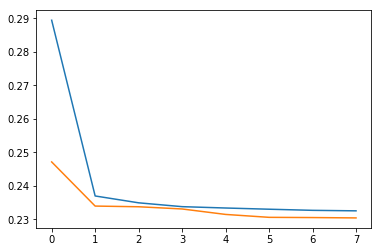

In [34]:
plt.plot(history.epoch, history.history["loss"])
plt.plot(history.epoch, history.history["val_loss"])

In [35]:
squared_error = 0
for i, y_hat in enumerate(model.predict(val_X, batch_size=256)):
    squared_error += (y_hat - val_y[i])**2
np.sqrt(squared_error/val_X.shape[0])

array([0.23044117])

In [36]:
val_y_ss.shape

NameError: name 'val_y_ss' is not defined

## Subsampling

In [130]:
random_indices = np.random.choice(np.arange(train_X.shape[0]), size=10000)
train_X_ss = train_X[random_indices, :]
train_y_ss = train_y[random_indices]

In [131]:
random_indices = np.random.choice(np.arange(val_X.shape[0]), size=10000)
val_X_ss = val_X[random_indices, :]
val_y_ss = val_y[random_indices]

## Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression

In [115]:
lm = LinearRegression()

In [117]:
lm.fit(train_X_ss, train_y_ss)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [118]:
lm.score(train_X_ss, train_y_ss)

0.092549754396408

In [120]:
y_pred = lm.predict(val_X_ss)

In [121]:
rmse(val_y_ss, y_pred)

0.24838268476285882

In [257]:
rmse(val_y_ss, np.mean(train_y))

0.25881588996885213

## Random Forest

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [110]:
rf = RandomForestRegressor(n_estimators = 100, max_depth=2000, min_samples_split=200, n_jobs=-1)
rf.fit(train_X_ss, train_y_ss)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2000,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=200,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [114]:
y_pred = rf.predict(val_X_ss)
rmse(val_y_ss, y_pred)

0.2875695208921693

In [90]:
param_grid = {"n_estimators" : [50, 100, 250],
              "max_depth" : [1000, 2000, 5000],
             "min_samples_split" : [10, 50, 100, 200]}

cv = GridSearchCV(RandomForestRegressor(),
                 param_grid=param_grid, cv=5, n_jobs=-1)

cv.fit(train_X_ss, train_y_ss)

In [106]:
cv.best_score_

0.15476595356374678

In [92]:
params = cv.best_params_

In [104]:
rf = RandomForestRegressor(n_estimators = params["n_estimators"],
                           max_depth = params["max_depth"],
                           min_samples_split = params["min_samples_split"], n_jobs=-1)
rf.fit(train_X_ss, train_y_ss)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=200,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [109]:
y_pred = rf.predict(val_X_ss)
rmse(val_y_ss, y_pred)

0.28580922872121495

## Regularized regression

In [132]:
from sklearn.linear_model import ElasticNet

In [138]:
alpha_values = np.array(list(map(lambda x: 1/10**x, np.arange(2,6))))
l1_ratio_values = np.arange(0, 0.1, 0.01)
param_grid = {"alpha" : alpha_values,
              "l1_ratio" : l1_ratio_values}
cv = GridSearchCV(ElasticNet(),
                 param_grid=param_grid, cv=5, n_jobs=-1)

cv.fit(train_X_ss, train_y_ss)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': array([1.e-02, 1.e-03, 1.e-04, 1.e-05]), 'l1_ratio': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [140]:
alpha_values

array([1.e-02, 1.e-03, 1.e-04, 1.e-05])

In [143]:
params = cv.best_params_

In [141]:
cv.best_score_

0.1645205947012965

In [145]:
lm = ElasticNet(alpha = params["alpha"],
               l1_ratio = params["l1_ratio"])

In [146]:
lm.fit(train_X, train_y)

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.07,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [148]:
y_pred = lm.predict(val_X)
rmse(val_y, y_pred)

0.23746662955911726

# Loading, imputing, changing data representations

In [2]:
data_folder = os.path.join(os.path.abspath(os.curdir), os.pardir, "data")

In [3]:
training_data = os.path.join(data_folder, "interim", "trimmed_train_train.csv")
train_df = pd.read_csv(training_data)
train_df = train_df.assign(image_path = train_df.image + ".jpg")

In [4]:
train_df.head()

,region,parent_category_name,category_name,param_1,title,description,price,user_type,image,deal_probability,user_active_ads,days_since_activation,image_path
0,Челябинская область,Для дома и дачи,Ремонт и строительство,Стройматериалы,Карнавал черный 6062 kerama marazzi,25*40 в количестве 3м2,650.0,Private,NaN,0.00000,6,17 days 00:00:00.000000000,NaN
1,Самарская область,Бытовая электроника,Телефоны,iPhone,Айфон 4s,"айфон в идеале,полный комплект ,торг мизерный,...",5000.0,Private,01ef194ae81da054c15816766fd2181e58cef40f507393...,0.76786,2,22 days 00:00:00.000000000,01ef194ae81da054c15816766fd2181e58cef40f507393...
2,Башкортостан,Для бизнеса,Оборудование для бизнеса,Промышленное,Пресс гидравлический,ПРЕСС ЭЛЕКТРО ГИДРАВЛИЧЕСКИЙ 30 ТОН НА 380 В,NaN,Private,bc7b416fd3244b57871ded4e58feeeafbfa87e42db20f2...,0.07656,1,17 days 00:00:00.000000000,bc7b416fd3244b57871ded4e58feeeafbfa87e42db20f2...
3,Ставропольский край,Транспорт,Автомобили,С пробегом,"ВАЗ 2112, 2004",Машина находится в залукокоаже. В хорошом сос...,147000.0,Private,138da7fca63186972a0812b970ef5f5732b5e8eb11bf29...,0.00000,1,16 days 00:00:00.000000000,138da7fca63186972a0812b970ef5f5732b5e8eb11bf29...
4,Башкортостан,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Продам свадебную накидку,Продам свадебную накидку,300.0,Private,98864bf47b62c720c1989e8062eeb642e3d1fbf9070dfe...,0.00000,2,10 days 00:00:00.000000000,98864bf47b62c720c1989e8062eeb642e3d1fbf9070dfe...


In [5]:
category_index_mapping = {category : int(index + 1) for index, category in enumerate(train_df.category_name.unique())}
region_index_mapping = {region : int(index + 1) for index, region in enumerate(train_df.region.unique())}
parent_category_index_mapping = {par_category : int(index + 1) for index, par_category in enumerate(train_df.parent_category_name.unique())}
param_1_index_mapping = {param_1 : int(index + 1) for index, param_1 in enumerate(train_df.param_1.unique())}

In [6]:
user_type_index_mapping = dict(zip(train_df.user_type.unique(), np.arange(1,4)))

In [7]:
user_type_index_mapping 

{'Private': 1, 'Shop': 2, 'Company': 3}

In [8]:
train_df = train_df.assign(category_index = train_df.category_name.map(category_index_mapping),
                           region_index = train_df.region.map(region_index_mapping),
                           parent_category_index = train_df.parent_category_name.map(parent_category_index_mapping),
                           param_1_index = train_df.param_1.map(param_1_index_mapping),
                           user_type_index = train_df.user_type.map(user_type_index_mapping))

In [9]:
train_df.head()

,region,parent_category_name,category_name,param_1,title,description,price,user_type,image,deal_probability,user_active_ads,days_since_activation,image_path,category_index,region_index,parent_category_index,param_1_index,user_type_index
0,Челябинская область,Для дома и дачи,Ремонт и строительство,Стройматериалы,Карнавал черный 6062 kerama marazzi,25*40 в количестве 3м2,650.0,Private,NaN,0.00000,6,17 days 00:00:00.000000000,NaN,1,1,1,1,1
1,Самарская область,Бытовая электроника,Телефоны,iPhone,Айфон 4s,"айфон в идеале,полный комплект ,торг мизерный,...",5000.0,Private,01ef194ae81da054c15816766fd2181e58cef40f507393...,0.76786,2,22 days 00:00:00.000000000,01ef194ae81da054c15816766fd2181e58cef40f507393...,2,2,2,2,1
2,Башкортостан,Для бизнеса,Оборудование для бизнеса,Промышленное,Пресс гидравлический,ПРЕСС ЭЛЕКТРО ГИДРАВЛИЧЕСКИЙ 30 ТОН НА 380 В,NaN,Private,bc7b416fd3244b57871ded4e58feeeafbfa87e42db20f2...,0.07656,1,17 days 00:00:00.000000000,bc7b416fd3244b57871ded4e58feeeafbfa87e42db20f2...,3,3,3,3,1
3,Ставропольский край,Транспорт,Автомобили,С пробегом,"ВАЗ 2112, 2004",Машина находится в залукокоаже. В хорошом сос...,147000.0,Private,138da7fca63186972a0812b970ef5f5732b5e8eb11bf29...,0.00000,1,16 days 00:00:00.000000000,138da7fca63186972a0812b970ef5f5732b5e8eb11bf29...,4,4,4,4,1
4,Башкортостан,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Продам свадебную накидку,Продам свадебную накидку,300.0,Private,98864bf47b62c720c1989e8062eeb642e3d1fbf9070dfe...,0.00000,2,10 days 00:00:00.000000000,98864bf47b62c720c1989e8062eeb642e3d1fbf9070dfe...,5,3,5,5,1


In [10]:
train_df = train_df.assign(days_since_activation_num = train_df.days_since_activation.str.slice(0,2).astype(int))

In [11]:
train_df.head()

,region,parent_category_name,category_name,param_1,title,description,price,user_type,image,deal_probability,user_active_ads,days_since_activation,image_path,category_index,region_index,parent_category_index,param_1_index,user_type_index,days_since_activation_num
0,Челябинская область,Для дома и дачи,Ремонт и строительство,Стройматериалы,Карнавал черный 6062 kerama marazzi,25*40 в количестве 3м2,650.0,Private,NaN,0.00000,6,17 days 00:00:00.000000000,NaN,1,1,1,1,1,17
1,Самарская область,Бытовая электроника,Телефоны,iPhone,Айфон 4s,"айфон в идеале,полный комплект ,торг мизерный,...",5000.0,Private,01ef194ae81da054c15816766fd2181e58cef40f507393...,0.76786,2,22 days 00:00:00.000000000,01ef194ae81da054c15816766fd2181e58cef40f507393...,2,2,2,2,1,22
2,Башкортостан,Для бизнеса,Оборудование для бизнеса,Промышленное,Пресс гидравлический,ПРЕСС ЭЛЕКТРО ГИДРАВЛИЧЕСКИЙ 30 ТОН НА 380 В,NaN,Private,bc7b416fd3244b57871ded4e58feeeafbfa87e42db20f2...,0.07656,1,17 days 00:00:00.000000000,bc7b416fd3244b57871ded4e58feeeafbfa87e42db20f2...,3,3,3,3,1,17
3,Ставропольский край,Транспорт,Автомобили,С пробегом,"ВАЗ 2112, 2004",Машина находится в залукокоаже. В хорошом сос...,147000.0,Private,138da7fca63186972a0812b970ef5f5732b5e8eb11bf29...,0.00000,1,16 days 00:00:00.000000000,138da7fca63186972a0812b970ef5f5732b5e8eb11bf29...,4,4,4,4,1,16
4,Башкортостан,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Продам свадебную накидку,Продам свадебную накидку,300.0,Private,98864bf47b62c720c1989e8062eeb642e3d1fbf9070dfe...,0.00000,2,10 days 00:00:00.000000000,98864bf47b62c720c1989e8062eeb642e3d1fbf9070dfe...,5,3,5,5,1,10


In [12]:
train_df.describe()

,price,deal_probability,user_active_ads,category_index,region_index,parent_category_index,param_1_index,user_type_index,days_since_activation_num
count,1.134319e+06,1.202739e+06,1.202739e+06,1.202739e+06,1.202739e+06,1.202739e+06,1.202739e+06,1.202739e+06,1.202739e+06
mean,3.298231e+05,1.392107e-01,1.318797e+01,1.211969e+01,1.299980e+01,4.684984e+00,3.478648e+01,1.514728e+00,1.644429e+01
std,7.475818e+07,2.601816e-01,5.873703e+01,1.018542e+01,8.215322e+00,2.141493e+00,4.760996e+01,8.432008e-01,4.045979e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,5.000000e+02,0.000000e+00,1.000000e+00,5.000000e+00,6.000000e+00,4.000000e+00,6.000000e+00,1.000000e+00,1.300000e+01
50%,1.300000e+03,0.000000e+00,2.000000e+00,6.000000e+00,1.200000e+01,5.000000e+00,1.400000e+01,1.000000e+00,1.600000e+01
75%,7.000000e+03,1.510200e-01,5.000000e+00,1.700000e+01,2.000000e+01,5.000000e+00,4.700000e+01,2.000000e+00,2.000000e+01
max,7.950101e+10,1.000000e+00,8.800000e+02,4.700000e+01,2.800000e+01,9.000000e+00,3.710000e+02,3.000000e+00,2.300000e+01


In [13]:
train_df.isna().sum()

region                           0
parent_category_name             0
category_name                    0
param_1                      49280
title                            0
description                  92801
price                        68420
user_type                        0
image                        90314
deal_probability                 0
user_active_ads                  0
days_since_activation            0
image_path                   90314
category_index                   0
region_index                     0
parent_category_index            0
param_1_index                    0
user_type_index                  0
days_since_activation_num        0
dtype: int64

In [14]:
train_df = train_df.fillna({"param_1" : 0,
                "description" : ""})

train_df.price.fillna(train_df.groupby("category_name")["price"].transform("mean"), inplace=True)

empty_img = Image.fromarray(np.zeros((224, 224, 3)).astype(np.uint8))

empty_img.show()

empty_img_path = os.path.join(data_folder, "external", "empty_img.jpg")

empty_img_path

empty_img.save(empty_img_path)

train_df.image_path[0]

image_folder = os.path.join(data_folder, "raw", "train_jpg", "data", "competition_files", "train_jpg")

empty_img_relpath = os.path.relpath(empty_img_path, image_folder)

train_df = train_df.fillna({"image_path" : empty_img_relpath})

features_to_keep = ["title", "description", "price", "deal_probability", "user_active_ads",\
                    "image_path", "category_index", "region_index", "parent_category_index",\
                   "param_1_index", "user_type_index", "days_since_activation_num"]

train_df = train_df[features_to_keep]

In [27]:
train_df.isna().sum()

title                        0
description                  0
price                        0
deal_probability             0
user_active_ads              0
image_path                   0
category_index               0
region_index                 0
parent_category_index        0
param_1_index                0
user_type_index              0
days_since_activation_num    0
dtype: int64

In [28]:
train_df.head()

,title,description,price,deal_probability,user_active_ads,image_path,category_index,region_index,parent_category_index,param_1_index,user_type_index,days_since_activation_num
0,Карнавал черный 6062 kerama marazzi,25*40 в количестве 3м2,650.000000,0.00000,6,..\..\..\..\..\external\empty_img.jpg,1,1,1,1,1,17
1,Айфон 4s,"айфон в идеале,полный комплект ,торг мизерный,...",5000.000000,0.76786,2,01ef194ae81da054c15816766fd2181e58cef40f507393...,2,2,2,2,1,22
2,Пресс гидравлический,ПРЕСС ЭЛЕКТРО ГИДРАВЛИЧЕСКИЙ 30 ТОН НА 380 В,316170.498692,0.07656,1,bc7b416fd3244b57871ded4e58feeeafbfa87e42db20f2...,3,3,3,3,1,17
3,"ВАЗ 2112, 2004",Машина находится в залукокоаже. В хорошом сос...,147000.000000,0.00000,1,138da7fca63186972a0812b970ef5f5732b5e8eb11bf29...,4,4,4,4,1,16
4,Продам свадебную накидку,Продам свадебную накидку,300.000000,0.00000,2,98864bf47b62c720c1989e8062eeb642e3d1fbf9070dfe...,5,3,5,5,1,10


In [29]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
from sklearn.preprocessing import OneHotEncoder

one_hot_enc = OneHotEncoder(categories="auto")

categorical_columns = ["category_index", "region_index", "parent_category_index",\
                      "param_1_index", "user_type_index"]

cat_X = one_hot_enc.fit_transform(train_df[categorical_columns])

cat_X.shape

In [37]:
from sklearn.linear_model import LinearRegression

In [35]:
train_X_lm = cat_X[:100000, :]
train_y_lm = train_df.deal_probability.values[:100000]

In [38]:
lm = LinearRegression()

In [39]:
lm.fit(train_X_lm, train_y_lm)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [40]:
lm.score(train_X_lm, train_y_lm)

0.17334326133983124

In [41]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

In [42]:
y_pred = lm.predict(cat_X[100000:200000, :])
y_true = train_df.deal_probability.values[100000:200000]
rmse(y_true, y_pred)

0.2374025062642079

In [53]:
alpha_vals = np.array(list(map(lambda x: 1/10**x, np.arange(1, 5))))

In [54]:
alpha_vals

array([0.1   , 0.01  , 0.001 , 0.0001])

In [56]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

estimator = Lasso()
param_grid = {"alpha" : alpha_vals}

param_grid

cv = GridSearchCV(estimator, param_grid, cv=5)

cv.fit(train_X_lm, train_y_lm)

cv.best_params_

cv.best_score_

lasso = cv.best_estimator_

In [57]:
y_pred = lasso.predict(cat_X[400000:500000, :])
y_true = train_df.deal_probability.values[400000:500000]
rmse(y_true, y_pred)

0.2391292304970656

In [72]:
rmse(y_true, train_df[:100000].deal_probability.mean())

0.26122014138961397

0.008997239728879225